# 04: Multilayer ANNs and Hyperparameter Experiments

### 🎯 Objective
This notebook builds a true **Multilayer Perceptron (MLP)**, an ANN with multiple hidden layers. We'll use it to solve a **non-linearly separable** problem that a simpler model would fail on. We will also refactor our code into functions to perform a hyperparameter experiment on the **learning rate**.

### 📚 Key Concepts
- **Non-Linear Separability:** Problems where a single straight line cannot separate the classes.
- **Multilayer Perceptron (MLP):** An ANN with one or more hidden layers, allowing it to learn non-linear boundaries.
- **Code Refactoring:** Writing code in functions (`createANNmodel`, `trainTheModel`) for reusability.
- **Hyperparameter Tuning:** Experimenting with parameters *about* the model (like learning rate) to find the best results.
- **Batch Training:** Running multiple models in a loop to compare their performance.

In [1]:
# import libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

## 1. Create the Data (A Non-Linear Problem)

Pay close attention to the coordinates of our two clusters:
- **Class 0 (Blue Squares):** Centered at `[1, 3]`
- **Class 1 (Black Circles):** Centered at `[1, -2]`

Both clusters are centered on the **same x-axis value** (`x=1`). This means a simple linear model, which can only draw a single straight line, cannot separate this data. You can't draw one line to divide a cluster at `y=3` from one at `y=-2` without cutting through them.

This is a **non-linearly separable** problem. We need a model that can learn a more complex decision boundary, which is the entire purpose of adding more layers.



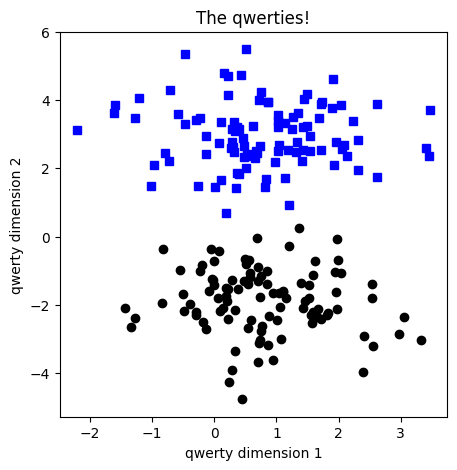

In [2]:
# create data

nPerClust = 100
blur = 1

A = [  1,  3 ] # Center for Class 0
B = [  1, -2 ] # Center for Class 1

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix (200x2)
# .T transposes from (features, samples) to (samples, features)
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

## 2. Refactoring Code into Functions

To run experiments, we need to create and train many models. The best practice for this is to wrap our model-building and training logic into functions. This makes our code clean, reusable, and easy to run in a loop.

In [3]:
def createANNmodel(learningRate):
  """
  This function builds a Multilayer ANN for binary classification
  Architecture: 2 -> 16 -> 1 -> 1
  """

  # model architecture
  ANNclassify = nn.Sequential(
      nn.Linear(2,16),  # Input layer: 2 features in, 16 neurons out
      nn.ReLU(),        # Activation for first hidden layer
      nn.Linear(16,1),  # First hidden layer: 16 neurons in, 1 neuron out
      nn.ReLU(),        # Activation for second hidden layer
      nn.Linear(1,1),   # Output layer: 1 neuron in, 1 neuron out
      nn.Sigmoid(),     # Final activation (for BCELoss)
        )

  # loss function
  lossfun = nn.BCELoss() # Binary Cross-Entropy
  # (Note: BCEWithLogitsLoss is more stable and preferred in practice)

  # optimizer
  optimizer = torch.optim.SGD(ANNclassify.parameters(),lr=learningRate)

  # model output
  return ANNclassify,lossfun,optimizer

In [4]:
# a function that trains the model

# a fixed parameter
numepochs = 1000

def trainTheModel(ANNmodel):
  """
  This function trains the model and returns the losses and final accuracy.
  """

  # initialize losses
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # forward pass
    yHat = ANNmodel(data)

    # compute loss
    loss = lossfun(yHat,labels)
    losses[epochi] = loss

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



  # final forward pass (on training data)
  predictions = ANNmodel(data)

  # compute the predictions and report accuracy
  # (predictions>.5) creates a boolean tensor [True,False,True...]
  # (== labels) compares element-wise to the true labels
  # .float() converts [True,False] to [1.0, 0.0]
  # torch.mean() calculates the average of this, which is the accuracy
  totalacc = 100*torch.mean(((predictions>.5) == labels).float())

  return losses,predictions,totalacc

## 3. Test the Functions (Single Run)

Let's run the model-building and training functions once with a learning rate of `0.01` to make sure everything works before we start the full experiment.

Final accuracy: 100%


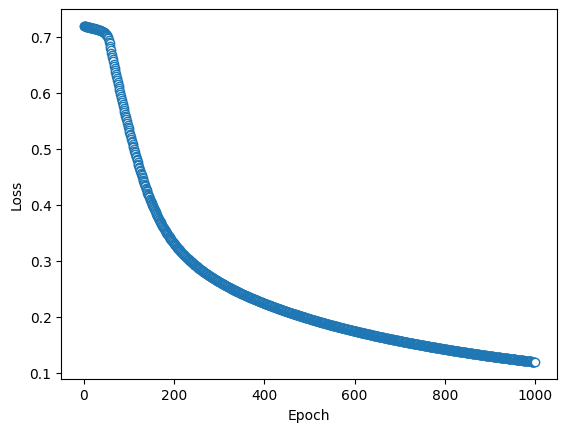

In [5]:
# create everything
ANNclassify,lossfun,optimizer = createANNmodel(.01)

# run it
losses,predictions,totalacc = trainTheModel(ANNclassify)

# report accuracy
print('Final accuracy: %g%%' %totalacc)


# show the losses
plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.show()

## 4. The Experiment: Testing Learning Rates

The **learning rate** is arguably the most important hyperparameter to tune.

- **Too High:** The optimizer "overshoots" the optimal solution. The loss will be unstable and jump around, and accuracy will be poor.
- **Too Low:** The optimizer takes tiny steps. It will train very slowly and may get "stuck" in a local minimum, unable to find the globally best solution.

We will now run a loop to train 50 different models, each with a unique learning rate, to find the "sweet spot".



In [6]:
# learning rates to test
learningrates = np.linspace(.001,.1,50)

# initialize results storage
accByLR = []
allLosses = np.zeros((len(learningrates),numepochs))


# the loop
for i,lr in enumerate(learningrates):

  # create and train the model
  # Note: We create a NEW, untrained model on each loop iteration
  ANNclassify,lossfun,optimizer = createANNmodel(lr)
  losses,predictions,totalacc = trainTheModel(ANNclassify)

  # store the results
  accByLR.append(totalacc)            # Store final accuracy
  allLosses[i,:] = losses.detach()    # Store all losses for this model

/tmp/ipython-input-176870781.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  allLosses[i,:] = losses.detach()    # Store all losses for this model


## 5. Visualizing Experiment Results

Now we plot the results of our 50-model experiment.

1.  **Plot 1 (Left):** Shows the **final accuracy** for each learning rate. We are looking for a region that is both **high** (good accuracy) and **stable** (not a single spike).
2.  **Plot 2 (Right):** Shows the **loss curves** for all 50 models overlaid. This helps us see *how* they trained.
    -   **Fast-dropping, low-plateau lines:** Good learning rates.
    -   **Slow-dropping, high-plateau lines:** Learning rates are too low.
    -   **Spiky, erratic lines:** Learning rates are too high.

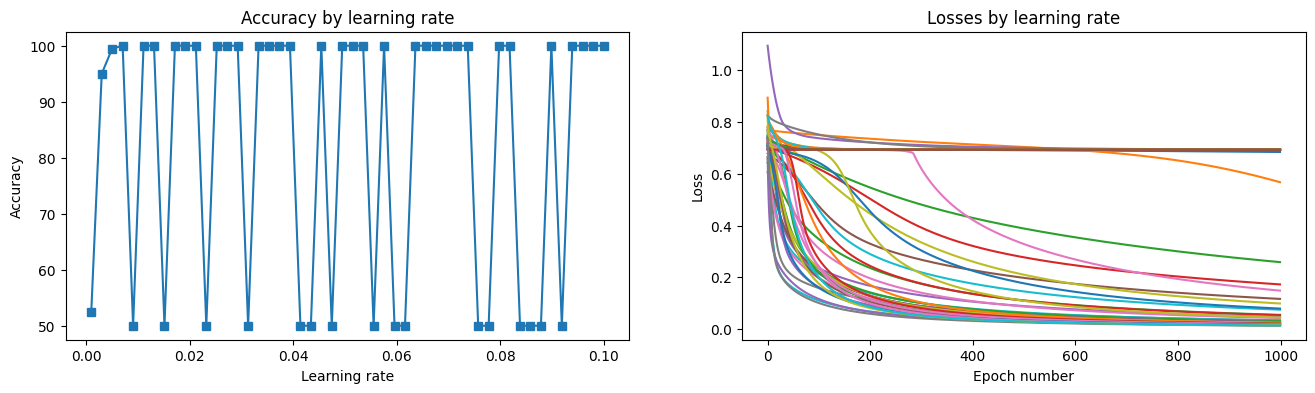

In [7]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(16,4))

ax[0].plot(learningrates,accByLR,'s-')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by learning rate')

ax[1].plot(allLosses.T)
ax[1].set_title('Losses by learning rate')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
plt.show()

In [8]:
# Print the raw accuracy results
print(accByLR)

[tensor(52.5000), tensor(95.), tensor(99.5000), tensor(100.), tensor(50.), tensor(100.), tensor(100.), tensor(50.), tensor(100.), tensor(100.), tensor(100.), tensor(50.), tensor(100.), tensor(100.), tensor(100.), tensor(50.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(50.), tensor(50.), tensor(100.), tensor(50.), tensor(100.), tensor(100.), tensor(100.), tensor(50.), tensor(100.), tensor(50.), tensor(50.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(50.), tensor(50.), tensor(100.), tensor(100.), tensor(50.), tensor(50.), tensor(50.), tensor(100.), tensor(50.), tensor(100.), tensor(100.), tensor(100.), tensor(100.)]


In [9]:
# Calculate the proportion of models that achieved >70% accuracy
# This gives us a sense of how 'stable' the training is.
prop_gt_70 = sum(torch.tensor(accByLR)>70)/len(accByLR)
print(f'{prop_gt_70*100:.2f}% of models had >70% accuracy.')

66.00% of models had >70% accuracy.
